# Packages and functions

In [55]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import pyBigWig as bw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Ellipse

import sys
sys.path.insert(0, '/home/jbreda/PROseq/scripts/Phase_to_LabColor')
from phase_to_labcolor import phase_to_labcolor as p2lc
sys.path.insert(0, '/home/jbreda/PROseq/scripts/FourierTransform')
from fourier_transform import fourier_transform


def get_data(coord, bw_folder, bin_size):

    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}

    [chr,start,end,strand] = coord.split(':')

    # get data from bigWigs
    df = pd.DataFrame(columns=['start','end'])
    for t in T:
        sample = f'CT{t:02d}'
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        bw_file = bw.open(fin)
        df_t = pd.DataFrame(bw_file.intervals(chr,int(start),int(end)),columns=['start','end',f"{t}"])
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df.sort_values('start',inplace=True)
    df.reset_index(inplace=True,drop=True)

    # replace start and end with position in the middle of the bin, and set as index
    df['start'] = ( (df.start.values + df.end.values)/2 ).astype(int) # bp
    df.drop('end',axis=1,inplace=True)
    df.columns = ['pos'] + df.columns[1:].tolist()
    df.set_index('pos',inplace=True)

    # fill missing values with 0, add pseudo count, log2 transform
    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log2(x+1),axis=1)
    
    return df

def plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf,fname):
    # put phi_kf - phi_n between -pi and pi
    idx_tl = (φ_kf - φ_n) > np.pi
    idx_br = (φ_n - φ_kf) > np.pi
    idx_tr = (φ_n + φ_kf) > 2*np.pi
    idx_bl = (φ_n + φ_kf) < 2*np.pi
    φ_n[idx_tl & idx_bl] += 2*np.pi
    φ_kf[idx_tl & idx_tr] -= 2*np.pi
    φ_kf[idx_br & idx_bl] += 2*np.pi
    φ_n[idx_br & idx_tr] -= 2*np.pi

    alpha = a_kf/a_kf.mean()
    alpha[alpha>1] = 1

    fig = plt.figure(figsize=(6,3))

    plt.subplot(121)
    plt.plot([0,2*np.pi],[0,2*np.pi],'k--',lw=1)
    plt.scatter(φ_n,φ_kf,s=3,marker='.',alpha=alpha)
    plt.xlabel('φ_n')
    plt.ylabel('φ_kf')

    plt.subplot(122)
    plt.hist(φ_kf - φ_n,bins=50)
    plt.xlabel(r'$\phi_{kf} - \phi_n$')
    plt.ylabel('count')
    plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],['-π','-π/2','0','π/2','π'])

    fig.savefig(fname,bbox_inches='tight')

def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])
    
def plot_phase_per_bin(x,f_n,μ_tT,φ_n,φ_kf,a_n,a_kf,Σ,k_t,k_mu,fname,tube=False):

    # phase/amp to color
    #h = φ_n/(2*np.pi)
    #s = a_n/np.nanmax(a_n)
    #v = np.ones(len(x))
    color_f = p2lc(φ_n)

    #h = φ_kf/(2*np.pi)
    #s = a_kf/a_kf.mean()
    #s[s>1] = 1
    #v = np.ones(len(x))
    color_kf = p2lc(φ_kf)

    # plot phase per bin
    Φ = np.ones((2,len(x),3))
    Φ[0,:] = color_f
    Φ[1,:] = color_kf

    fig = plt.figure(figsize=(30,1))
    fig, axes = plt.subplots(2, 1, figsize=(20, 6), gridspec_kw={'height_ratios': [1, 10]})

    ax = axes[0]
    ax.imshow(Φ,aspect='auto',interpolation='none')

    ax = axes[1]
    ax.errorbar(x,k_t,np.sqrt(Σ[:,2,2]))

    ax.plot([x[0],x[-1]],[k_mu,k_mu],'k--')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('k')
    dx = x[1] - x[0]
    ax.set_xlim([x[0]-dx/2,x[-1]+dx/2])

    fig.savefig(fname[0],bbox_inches='tight')

    # plot amp and phase per bin in 3D
    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(30,360,90) ):
        ax = fig.add_subplot(2,2,f+1, projection='3d')
        ax.scatter(xs=f_n[~np.isnan(f_n)].real, ys=f_n[~np.isnan(f_n)].imag, zs=x[~np.isnan(f_n)], color=Φ[0,~np.isnan(f_n)],s=10,marker='o')
        ax.plot3D(f_n[~np.isnan(f_n)].real, f_n[~np.isnan(f_n)].imag, x[~np.isnan(f_n)], color='k',lw=.1)

        Re = μ_tT.real
        Im = μ_tT.imag
        ax.scatter(xs=Re, ys=Im, zs=x, color='k',s=10,marker='.',alpha=.2)
        if tube:
            for i in range(len(x)):
                cov = Σ[i,:2,:2]
                pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
                ell_radius_x = np.sqrt(1 + pearson)
                ell_radius_y = np.sqrt(1 - pearson)
                ell = Ellipse((Re[i], Im[i]), width=ell_radius_x * 2, height=ell_radius_y * 2,facecolor='none',edgecolor='k',angle=45,alpha=.1)
                ax.add_patch(ell)
                pathpatch_2d_to_3d(ell,z=x[i],normal='z')

        ax.plot3D([0,0],[0,0],[x[0],x[-1]],color='k',lw=3)
        ax.view_init(elev=30, azim=azim, roll=0)
        ax.set_xlabel('Re')
        ax.set_ylabel('Im')
        ax.set_zlabel('position')

    fig.savefig(fname[1],bbox_inches='tight')



# test phase inference

Text(0.5, 1.0, 'Phase rel err')

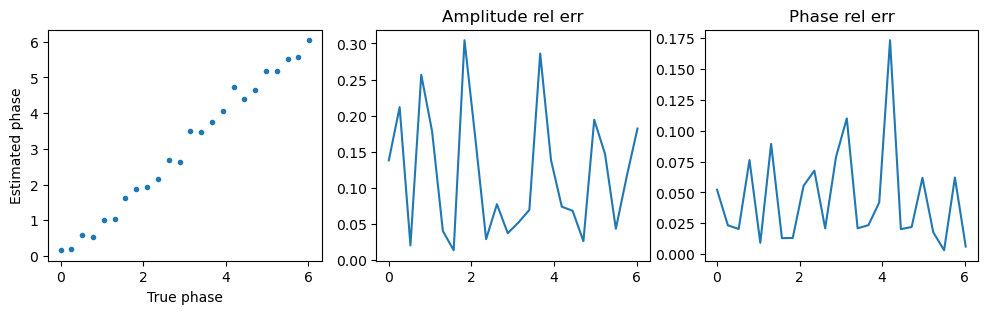

In [9]:
T = np.arange(0,48,4)
ω = 2*np.pi/24

# simulate signal
t_phase = np.arange(0,24,1)
Φ = t_phase/24*(2*np.pi)
Φ_f = np.zeros(Φ.shape[0])

err_amp_phi = np.zeros([2,Φ.shape[0]])

m = T.shape[0]
H = np.zeros((m,3))
H[:,0] = np.cos(ω*T)
H[:,1] = -np.sin(ω*T)
H[:,2] = 0
H /= 6

for i,φ in enumerate(Φ):
    A = 4.2
    mu = 12
    x_true = mu + A*np.cos(ω*T - φ) + 2*np.random.randn(T.shape[0])

    # fourier transform
    f_n = np.sum(x_true*np.exp(-1j*ω*T))
    a_n = np.abs(f_n)*2/T.shape[0]
    Φ_f[i] = -np.arctan2(np.imag(f_n),np.real(f_n))
    # put between 0 and 2pi
    Φ_f[Φ_f < 0] += 2*np.pi
    mu_n = np.mean(x_true)
    x_hat = mu_n + H @ np.array([f_n.real,f_n.imag,0])

    err_amp_phi[0,i] = np.abs(A - a_n)/A
    err_amp_phi[1,i] = np.abs(φ - Φ_f[i])/np.pi

# make sure error on phase is between 0 and pi
err_amp_phi[1,err_amp_phi[1] > np.pi] = 2*np.pi - err_amp_phi[1,err_amp_phi[1] > np.pi]

fig, axes = plt.subplots(1,3,figsize=(12,3))
ax = axes[0]
ax.plot(Φ,Φ_f,'.')
ax.set_xlabel('True phase')
ax.set_ylabel('Estimated phase')
ax = axes[1]
ax.plot(Φ,err_amp_phi[0,:])
ax.set_title('Amplitude rel err')
ax = axes[2]
ax.plot(Φ,err_amp_phi[1,:])
ax.set_title('Phase rel err')



# Continuous-time extended Kalman filter

## 3D state (a,b,k)

### Toy model

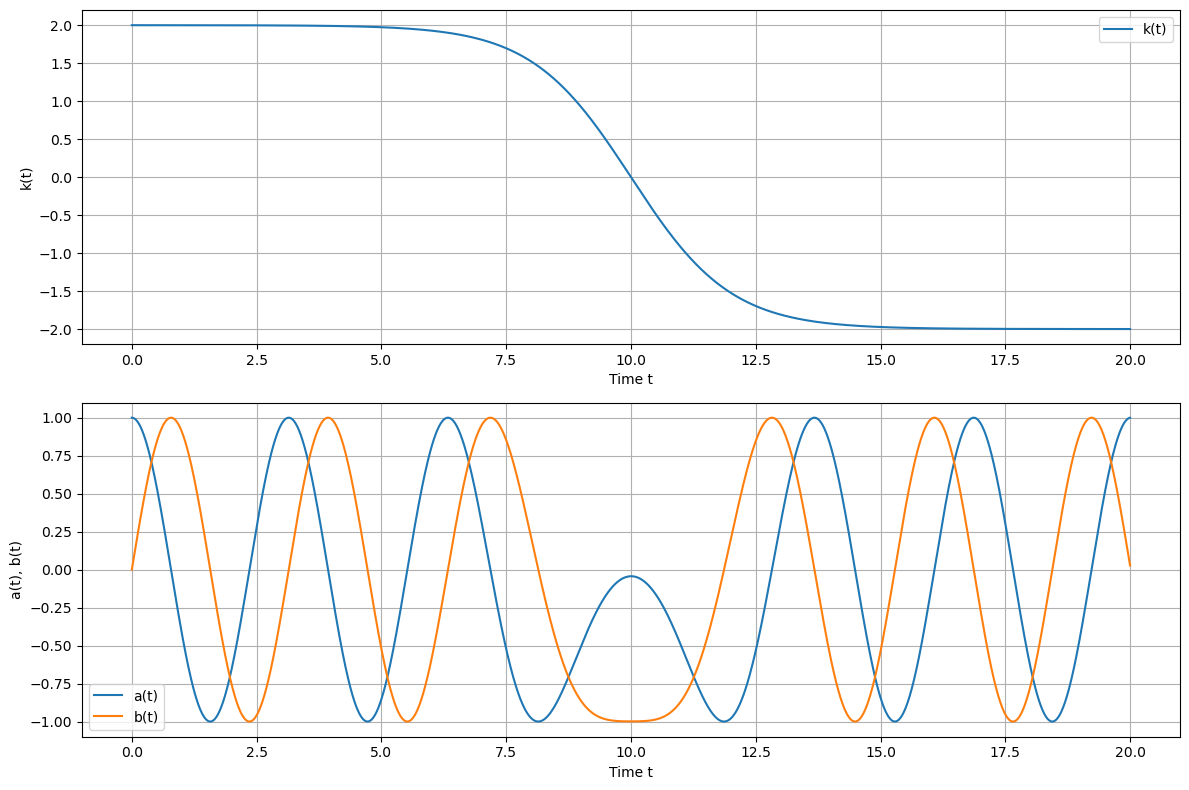

In [5]:
def analytical_solution(t, a0, b0, k0, gamma, k_μ):
    
    # Calculate k(t), a(t), and b(t)
    k_t = np.exp(-gamma * t) * (k0 - k_μ) + k_μ
    argument =  (k0 -k_t) / gamma + k_μ * t
    a_t = a0 * np.cos(argument) - b0 * np.sin(argument)
    b_t = b0 * np.cos(argument) + a0 * np.sin(argument)
    
    return a_t, b_t, k_t


# Parameters
a0 = 1.0  # Initial value of a
b0 = 0.0  # Initial value of b
k0 = 0.0  # Initial value of k
gamma = .1  # Parameter gamma
k_mu = 2.0  # Parameter k_mu
t = np.linspace(0, 20, 3000)  # Time points

# Compute the analytical solutions
Sol = np.zeros((3, t.shape[0]))
Sol[:,0] = [a0, b0, k0]
Sol[2,:] = 4*( 1/(1 + np.exp(1*(t - 10))) - .5)
for i in range(len(t)):
    if i == 0:
        continue
    dt = t[i] - t[i-1]
    a_t, b_t, k_t = Sol[:,i-1]
    a_t, b_t, k_t = analytical_solution(dt, a_t, b_t, k_t, gamma, k_mu)
    Sol[:2,i] = [a_t, b_t]

# Plot the results
plt.figure(figsize=(12, 8))

a_t = Sol[0,:]
b_t = Sol[1,:]
k_t = Sol[2,:]

# Plot k(t)
plt.subplot(2, 1, 1)
plt.plot(t, k_t, label='k(t)')
plt.xlabel('Time t')
plt.ylabel('k(t)')
plt.legend()
plt.grid()        amp = np.array(amp)

# Plot a(t) and b(t) for the first solution
plt.subplot(2, 1, 2)
plt.plot(t, a_t, label='a(t)')
plt.plot(t, b_t, label='b(t)')
plt.xlabel('Time t')
plt.ylabel('a(t), b(t)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Signal to noise:  1.388888888888889


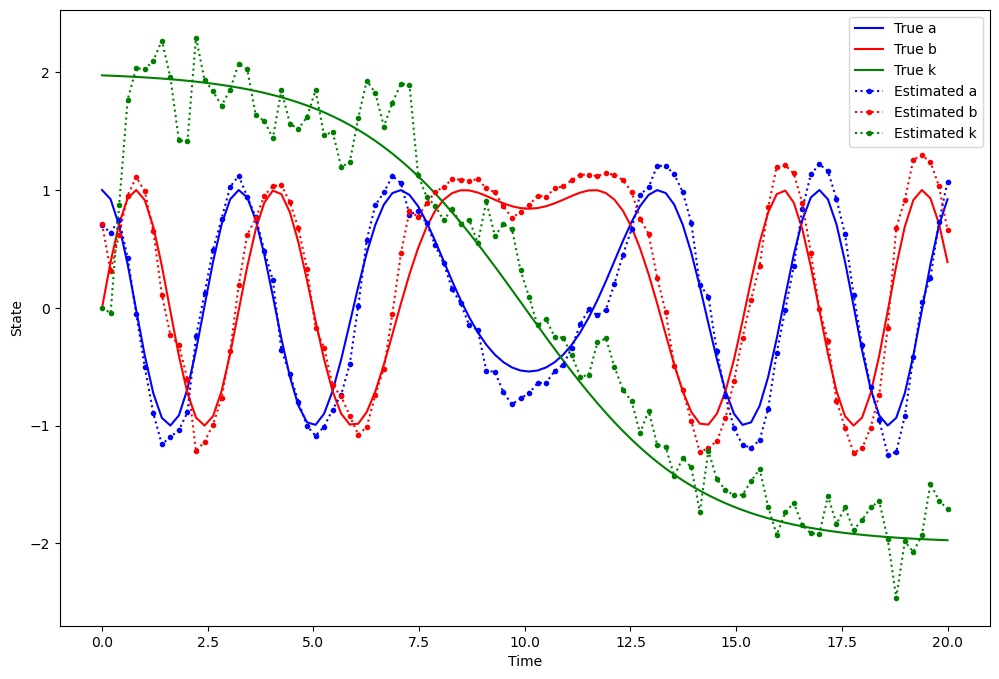

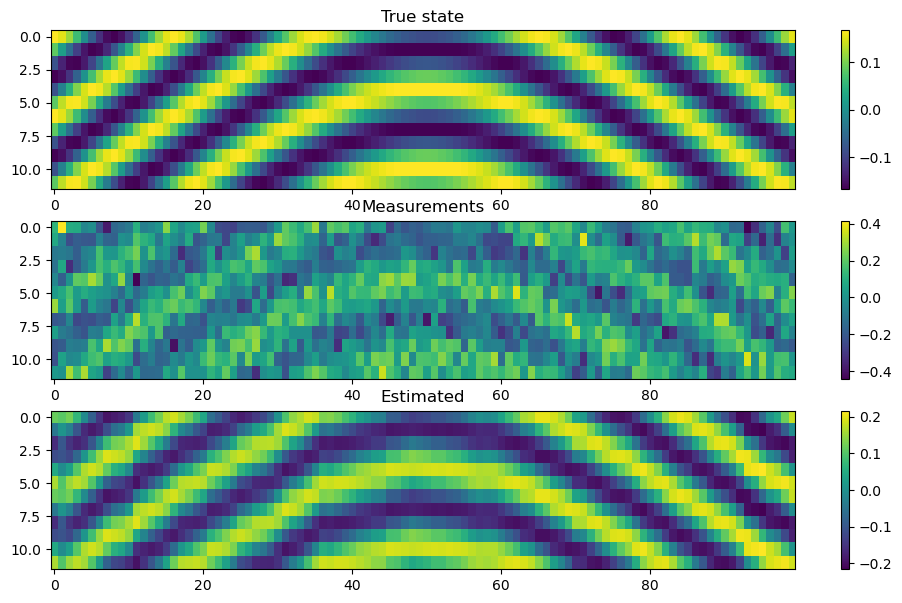

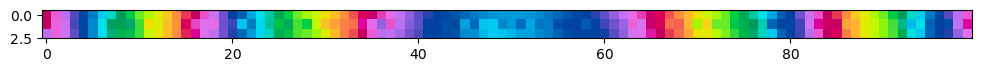

In [10]:
# Define system dynamics
def f(t, x, γ, k_μ):
    a, b, k = x
    da = -k * b
    db = k * a
    dk = γ * (k_μ - k)
    return [da, db, dk]

# Define the Jacobian of f
def F_jacobian(x, gamma):
    a, b, k = x
    return np.array([
        [0, -k, -b],
        [k, 0, a],
        [0, 0, -gamma]])

def f_analytical_solution(t, x0, γ, k_μ):
    a0, b0, k0 = x0
    # Calculate k(t), a(t) and b(t)
    k_t = np.exp(-γ*t) * (k0 - k_μ) + k_μ
    argument =  (k0 - k_t)/γ + k_μ * t
    a_t = a0 * np.cos(argument) - b0 * np.sin(argument)
    b_t = b0 * np.cos(argument) + a0 * np.sin(argument)
    
    return a_t, b_t, k_t

#def f_analytical_solution(t, x0, gamma):
#    a0, b0, k0 = x0
#    k_t = k0 * np.exp(-gamma * t)
#    fac = (k0 - k_t)/gamma
#    a_t = a0 * np.cos(fac) - b0 * np.sin(fac)
#    b_t = a0 * np.sin(fac) + b0 * np.cos(fac)
#    return a_t, b_t, k_t

# Define measurement function: inverse fourier transform
def h(x,ω,T):
    H = np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0])]).T *2/T.shape[0]
    return H @ x

# Define the Jacobian of h
def H_jacobian(x,ω,T):
    return np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0])]).T *2/T.shape[0]

# P(t)' = F(t)P(t) + P(t)F(t)^T + Q
def dPdt(t,P,F,Q):
    P = P.reshape((3, 3))  # Reshape the 1D array P into a 3x3 matrix
    return (F @ P + P @ F.T + Q).flatten() # Flatten the 3x3 matrix to a 1D array of size 9

T = np.arange(0,48,4)
ω = 2*np.pi/24

# Simulation
t_eval = np.linspace(0, 20, 100)
# K as a hill function of time from 2 to -2
k_sim = 4*( 1/(1 + np.exp(.5*(t_eval - 10))) - .5)
true_C = np.zeros((3, t_eval.shape[0]))
true_C[2,:] = k_sim
true_C[:2,0] = [1, 0]
for i,t in enumerate(t_eval):
    if i == 0:
        continue
    dt = t - t_eval[i-1]
    a0, b0, k0 = true_C[:,i-1]
    at = a0*np.cos(k0*dt) - b0*np.sin(k0*dt)
    bt = a0*np.sin(k0*dt) + b0*np.cos(k0*dt)
    true_C[:2,i] = [at, bt]
true_R = h(true_C,ω,T)
sigma = 0.1
measurements = true_R  + np.random.normal(0,sigma, size=true_R.shape)
print('Signal to noise: ', np.var(true_R)/sigma**2 )

ONE = np.eye(3)
kmu = 0

# Initialize parameters
m = T.shape[0]
gamma = .1  # Parameter gamma
k_mu = 0 # Parameter k_mu
x_0 = np.array([a0, b0, kmu])
sigma = 1e-5
Q = np.eye(3)*(sigma)**2
Q[2,2] = 0.1  # Process noise cond covariance
x_hat = x_0
x_est = np.zeros((len(t_eval),x_hat.shape[0]))
x_est[0] = x_hat
P_pred = ONE.flatten()
P_est = np.zeros((len(t_eval),P_pred.shape[0]))
P_est[0] = P_pred
R = (.05)**2*np.diag(np.ones(m))  # Measurement noise covariance

# EKF implementation
# Initial state estimate and covariance
x_hat = x_0
x_est = np.zeros((len(t_eval),x_hat.shape[0]))
x_est[0] = x_hat
P_pred = ONE.flatten()
P_est = np.zeros((len(t_eval),P_pred.shape[0]))
P_est[0] = P_pred
LL = np.zeros(len(t_eval))

for i in range(1,len(t_eval)):

    # Predict
    F = F_jacobian(x_hat, gamma)
    solP = solve_ivp(dPdt, [t_eval[i-1], t_eval[i]], P_pred, args=(F,Q,))
    P_pred = solP.y[:, -1]
    x_hat = f_analytical_solution(t_eval[i] - t_eval[i-1], x_hat, gamma, k_mu)

    # Update
    H = H_jacobian(x_hat,ω,T)
    S = np.linalg.multi_dot([H,P_pred.reshape((3,3)),H.T]) + R
    K = np.linalg.multi_dot([P_pred.reshape((3,3)), H.T, np.linalg.inv(S)])
    y = measurements[:, i] - h(x_hat,ω,T)
    x_hat = x_hat + K @ y
    P_pred = ( (ONE - K @ H) @ P_pred.reshape((3,3)) ).flatten()

    # Save results
    x_est[i] = x_hat
    P_est[i] = P_pred
    LL[i] = -0.5 * np.linalg.multi_dot([y.T, np.linalg.inv(S), y]) + np.log(np.linalg.det(S)) + m * np.log(2*np.pi)
z_est = h(x_est.T,ω,T)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t_eval, true_C[0,:], label='True a', color='blue')
plt.plot(t_eval, true_C[1,:], label='True b', color='red')
plt.plot(t_eval, true_C[2,:], label='True k', color='green')
plt.plot(t_eval, x_est[:, 0], '.:', label='Estimated a', color='blue')
plt.plot(t_eval, x_est[:, 1], '.:', label='Estimated b', color='red')
plt.plot(t_eval, x_est[:, 2], '.:', label='Estimated k', color='green')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()


fig, ax = plt.subplots(3,1,figsize=(12,7))
plt.colorbar( ax[0].imshow(true_R, aspect='auto') )
ax[0].set_title('True state')
plt.colorbar( ax[1].imshow(measurements, aspect='auto') )
ax[1].set_title('Measurements')
plt.colorbar( ax[2].imshow(z_est,  aspect='auto') )
ax[2].set_title('Estimated')
plt.show()


[φ_t, a_t, R2_t, pval_t, μ_t] = fourier_transform(true_R.T,T,ω)
[φ_m, a_m, R2_m, pval_m, μ_m] = fourier_transform(measurements.T,T,ω)
[φ_e, a_e, R2_e, pval_e, μ_e] = fourier_transform(z_est.T,T,ω)
Φ = np.ones((3,len(t_eval),3))
Φ[0,:,:] = p2lc(φ_t)
Φ[1,:,:] = p2lc(φ_m)
Φ[2,:,:] = p2lc(φ_e)

fig, ax = plt.subplots(1,1,figsize=(12,3))    
plt.imshow(Φ,aspect='equal',interpolation='none')




### On data

In [1]:
# Define system dynamics
def f(t, x, γ, k_μ):
    a, b, k = x
    da = -k * b
    db = k * a
    dk = γ * (k_μ - k)
    return [da, db, dk]

# Define the Jacobian of f
def F_jacobian(x, gamma):
    a, b, k = x
    return np.array([
        [0, -k, -b],
        [k, 0, a],
        [0, 0, -gamma]])

def f_analytical_solution(t, x0, γ, k_μ):
    a0, b0, k0 = x0
    # Calculate k(t), a(t) and b(t)
    k_t = np.exp(-γ*t) * (k0 - k_μ) + k_μ
    argument =  (k0 - k_t)/γ + k_μ * t
    a_t = a0 * np.cos(argument) - b0 * np.sin(argument)
    b_t = b0 * np.cos(argument) + a0 * np.sin(argument)
    
    return a_t, b_t, k_t

# Define measurement function: inverse fourier transform
def h(x,ω,T):
    H = np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0])]).T *2/T.shape[0]
    return H @ x

# Define the Jacobian of h
def H_jacobian(x,ω,T):
    return np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0])]).T *2/T.shape[0]

# P(t)' = F(t)P(t) + P(t)F(t)^T + Q
def dPdt(t,P,F,Q):
    P = P.reshape((3, 3))  # Reshape the 1D array P into a 3x3 matrix
    return (F @ P + P @ F.T + Q).flatten() # Flatten the 3x3 matrix to a 1D array of size 9

# Time span for simulation
# GRCm39
#MY_WINS = [['chr17',34_760_000, 34_920_000,'-','reg1'],
#           ['chr17',26_750_000, 27_050_000,'+','reg2'],
#           ['chr7',19_388_855,19_487_718,'-','reg3'],
#           ['chr1',68_071_345,69_147_218,'-','Erbb4']]
# GRCm38
MY_WINS = [['chr17',34_850_000, 35_150_000,'-','reg1'],
           ['chr17',26_500_000, 26_800_000,'+','reg2'],
           ['chr7',19_650_855,19_880_000,'-','reg3'],
           ['chr1',67_900_000,69_200_000,'-','Erbb4'],
           ['chr10',125_000_000,130_000_000,'+', 'reg5']]

bw_folder = '../results/GRCm38/binned_norm_coverage'
bin_size = 1000 # bin size
T = np.arange(0,48,4) # time points
P = 24 # period
ω = 2*np.pi/P # angular frequency [rad/h]
m = len(T) # number of time points
n = 3 # number of hidden states
dx = bin_size*1e-3 # distance between positions [kb]
v_mean = 34 # [bp/s]
k_mean = (ω/3600)/v_mean # [rad/bp]

# get noise model parameters
fin = open(f'{bw_folder}/Noise_model_parameters_{bin_size}bp.csv','r')
lines = fin.readlines()
Noise_params = {}
for line in lines:
    if line[0] == '#':
        continue
    line = line.strip().split('\t')
    Noise_params[line[0]] = float(line[1])
fin.close()

# Initialize parameters
sigma_z = 1e-6 # variance the process ( z(x) = a(x) + ib(x) )
gamma = 5e-2   # rate of mean reversion of k(t)
k_mu = -k_mean * 1e3 # mean of k(t) [rad/kb]
sigma_k = 2e-2 # variance k(t) process

Q = np.eye(n)*(sigma_z*dx)**2
Q[2,2] = 2*gamma*(sigma_k*dx)**2  # Volatility of Ornstien-Uhlenbeck process

for My_win in MY_WINS[-1:]:

    # get data
    [chr,start,end,strand,name] = My_win
    print(name)
    coord = f'{chr}:{start}:{end}:{strand}'
    df = get_data(coord,bw_folder,bin_size)
    positions = df.index*1e-3 # positions [kb]
    measurments = df.values.T # time x position
    if strand == '-':
        measurments = measurments[:,::-1]
        positions = -positions[::-1]

    # Use unnormalized expression at each position for R
    R = np.zeros((len(positions),m,m))
    # exponential decay of R as a function of z :  R(x) = a * exp(-b * x) + c
    for i in range(len(positions)):
        if np.isnan(measurments[:,i]).all():
            continue
        r_i = Noise_params['a'] * np.exp(-Noise_params['b'] * measurments[:,i] ) + Noise_params['c']
        r_i[measurments[:,i] < Noise_params['m_err_max']] = Noise_params['err_max']
        R[i,:,:] = np.diag(r_i)
    R *= 1e1

    # normalization
    X = measurments - np.mean(measurments,axis=0,keepdims=True)
    X = X / np.std(X,axis=0,keepdims=True)

    # fourier transform bin by bin
    f_n = np.sum(X.T*np.exp(-1j*ω*T),1)
    φ_n, a_n, R2, pval, μ = fourier_transform(X,T,ω)
    φ_n[R2<0.2] = np.nan
    f_n[R2<0.2] = np.nan
    
    # EKF implementation
    # Initial state estimate and covariance
    a0 = np.nanmean(f_n.real[:10])
    b0 = np.nanmean(f_n.imag[:10])
    x0 = np.array([a0,b0,k_mu])

    x_pred = np.zeros((len(positions),x0.shape[0]))
    x_est = np.zeros((len(positions),x0.shape[0]))

    P0 = np.diag([sigma_z, sigma_z, sigma_k]).flatten()  # Initial state covariance (3x3)-matrix -> (9)-vector
    P_pred = np.zeros((len(positions),P0.shape[0]))
    P_est = np.zeros((len(positions),P0.shape[0]))

    LL = np.zeros(len(positions))

    # Forward filter
    for k in range(len(positions)):
        print(k/len(positions))

        # Predict
        if k == 0:
            x_pred[k] = x0
            P_pred[k] = P0
        else:
            x_pred[k] = f_analytical_solution(positions[k] - positions[k-1], x_est[k-1], gamma, k_mu)
            F = F_jacobian(x_pred[k], gamma)
            #Q_t = Q
            solP = solve_ivp(dPdt, [positions[k-1], positions[k]], P_est[k-1], args=(F,Q,))
            P_pred[k] = solP.y[:, -1]
            
        
        # Update
        H = H_jacobian(x_pred[k],ω,T)
        S = np.linalg.multi_dot([H,P_pred[k].reshape((3,3)),H.T]) + R[k]
        K = np.linalg.multi_dot([P_pred[k].reshape((3,3)), H.T, np.linalg.inv(S)])
        res = X[:, k] - h(x_pred[k],ω,T)
        x_est[k] = x_pred[k] + K @ (res)
        P_est[k] = ( (np.eye(3) - K @ H) @ P_pred[k].reshape((3,3)) ).flatten()
        
        # Log likelihood
        LL[k] = -0.5 * ( np.linalg.multi_dot([res.T, np.linalg.inv(S), res]) + np.log(np.linalg.det(S)) + m * np.log(2*np.pi) )

    # Backward smoother
    x_smooth = np.zeros((len(positions),x0.shape[0]))
    P_smooth = np.zeros((len(positions),P0.shape[0]))
    x_smooth[-1] = x_est[-1]
    P_smooth[-1] = P_est[-1]
    for k in range(len(positions)-2,-1,-1):
        F = F_jacobian(x_est[k], gamma)
        J = np.linalg.multi_dot([P_est[k].reshape((3,3)), F.T, np.linalg.inv(P_pred[k+1].reshape((3,3)))])
        x_smooth[k] = x_est[k] + J @ (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = ( P_est[k].reshape((3,3)) + J @ (P_smooth[k+1].reshape((3,3)) - P_pred[k+1].reshape((3,3))) @ J.T ).flatten()


    z_est = h(x_est.T,ω,T)
    P_est = P_est.reshape((len(positions),3,3))
    z_smooth = h(x_smooth.T,ω,T)
    P_smooth = P_smooth.reshape((len(positions),3,3))
    

    # Amp and phase of kalman filter
    μ_tT = x_smooth[:,0] + 1j*x_smooth[:,1]
    a_kf = 4/m * np.abs(μ_tT)
    φ_kf = -np.arctan2(np.imag(μ_tT),np.real(μ_tT))
    φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
    k_tT = x_est[:,2]

    
    # give amp 1 to all f_n
    #f_n = f_n/np.abs(f_n)
    # inverse fourier 
    #X = (f_n * np.exp(1j*ω*T[:,None])).real

    plot_phase_per_bin(positions,f_n,μ_tT,φ_n,φ_kf,a_n,a_kf,P_smooth,k_tT,k_mu,fname=[f'fig/continuous_time_extended_kalman/kalman_smooth_{name}_kf.pdf',f'fig/continuous_time_extended_kalman/kalman_smooth_{name}_kf_3D.pdf'],tube=True)
    plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf,fname='fig/continuous_time_extended_kalman/kalman_scatter_phi_{name}.pdf')
        
    


NameError: name 'np' is not defined

## 4D state (a,b,k,lambda): variable lenght lambda(t)

### On data

reg6
Forward filter
Backward smoother16


/home/jbreda/miniforge3/envs/pro-seq/lib/python3.12/site-packages/matplotlib/cm.py:411: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


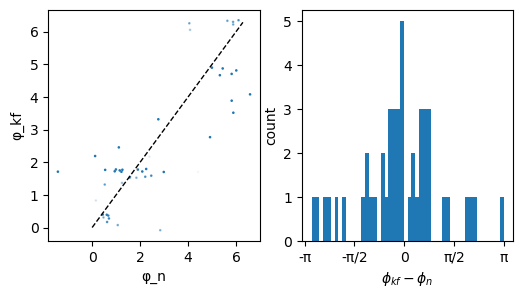

<Figure size 3000x100 with 0 Axes>

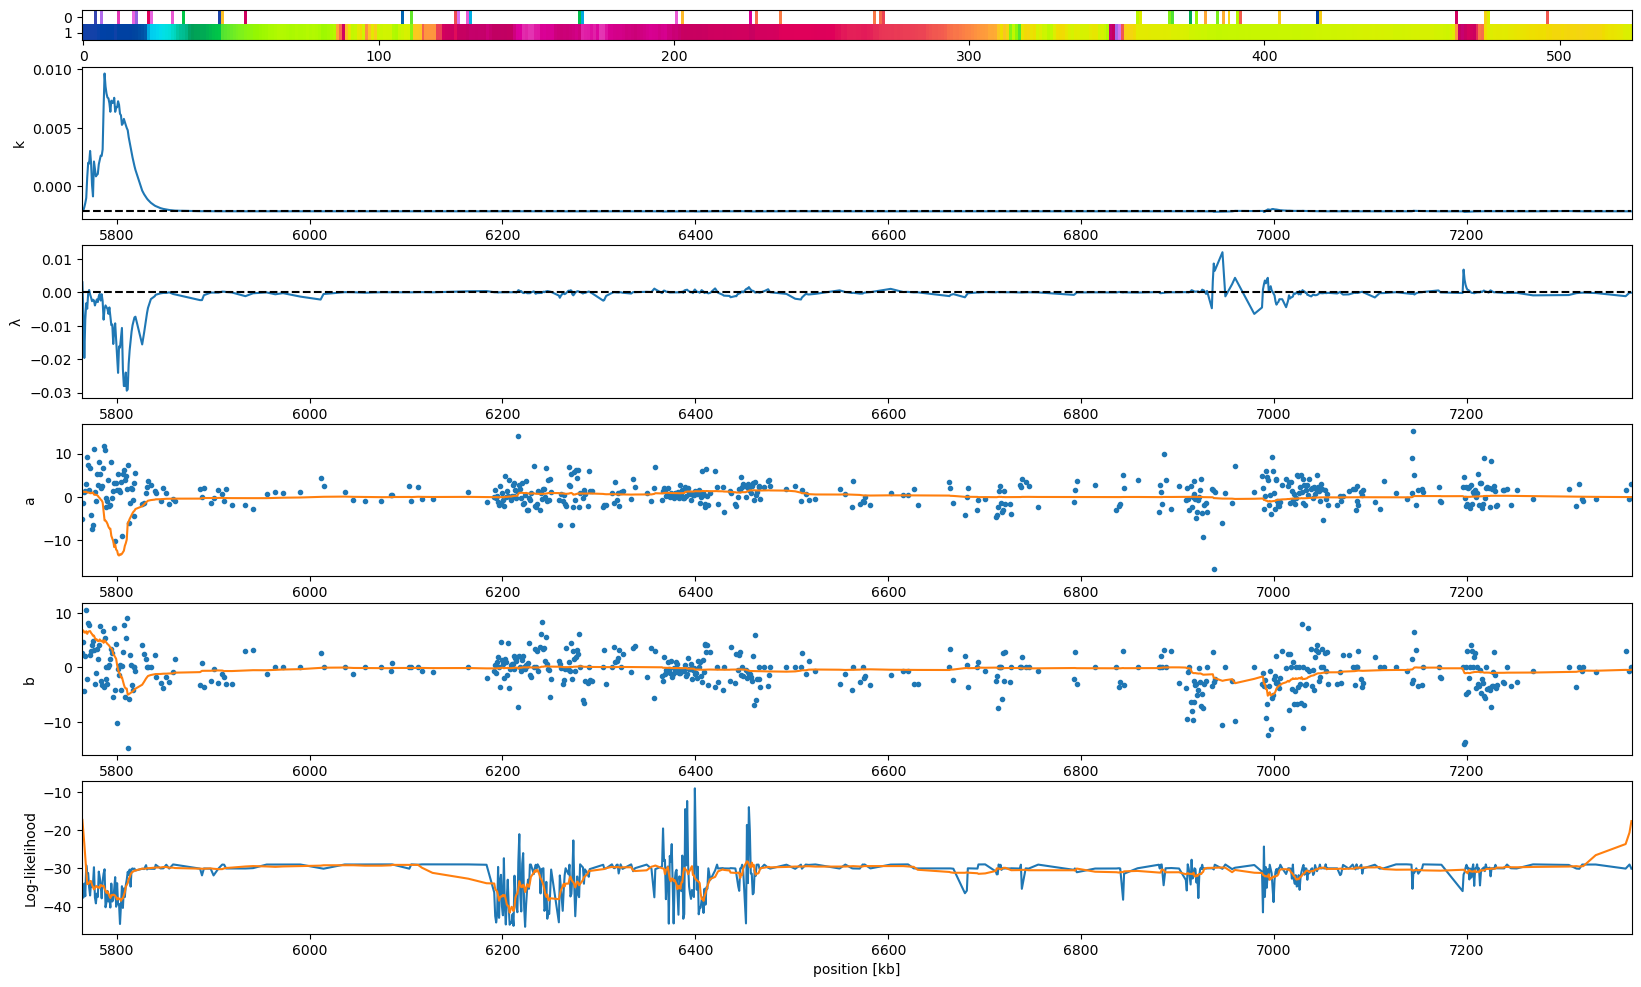

In [57]:
# Define system dynamics
#def f(t, x, γ, k_μ):
#    a, b, k = x
#    da = -k * b
#    db = k * a
#    dk = γ * (k_μ - k)
#    return [da, db, dk]

def f_analytical_solution(Δt, x0, γ_k, k_μ, γ_l):
    a0, b0, k0, λ0 = x0

    # Calculate k(t), lambda(t), a(t) and b(t)
    k_t = np.exp(-γ_k*Δt) * (k0 - k_μ) + k_μ
    λ_t = np.exp(-γ_l*Δt) * λ0

    argument =  (k0 - k_t)/γ_k + k_μ * Δt
    factor = np.exp( (λ0-λ_t)/γ_l )

    a_t = factor * ( a0 * np.cos(argument) - b0 * np.sin(argument) )
    b_t = factor * ( b0 * np.cos(argument) + a0 * np.sin(argument) )
    
    return a_t, b_t, k_t, λ_t

# Define the Jacobian of f
def F_jacobian(x, γ_k, γ_l):
    a, b, k, λ = x
    
    return np.array([
        [λ, -k, -b, a],
        [k, λ, a, b],
        [0, 0, -γ_k,0],
        [0, 0, 0, -γ_l]])

# Define measurement function: inverse fourier transform
def h(x,ω,T):
    H = np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0]), np.zeros(T.shape[0])]).T *2/T.shape[0]
    return H @ x

# Define the Jacobian of h
def H_jacobian(x,ω,T):
    return np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0]), np.zeros(T.shape[0])]).T *2/T.shape[0]

# P(t)' = F(t)P(t) + P(t)F(t)^T + Q
def dPdt(t,P,F,Q):
    P = P.reshape((4, 4))  # Reshape the 1D array P into a 3x3 matrix
    return (F @ P + P @ F.T + Q).flatten() # Flatten the 3x3 matrix to a 1D array of size 9


# Time span for simulation
# GRCm39
#MY_WINS = [['chr17',34_850_000, 35_150_000,'-','reg1'],
#           ['chr17',26_750_000, 27_050_000,'+','reg2'],
#           ['chr7',19_388_855,19_487_718,'-','reg3'],
#           ['chr1',68_071_345,69_147_218,'-','Erbb4']]
# GRCm38
MY_WINS = [['chr17', 34_850_000, 35_150_000,'-','reg1'],
           ['chr17', 26_500_000, 26_800_000,'+','reg2'],
           ['chr7',  19_650_855, 19_880_000,'-','reg3'],
           ['chr1',  67_900_000, 69_200_000,'-','Erbb4'],
           ['chr10',125_000_000,130_000_000,'+', 'reg5+'],
           ['chr10',125_000_000,130_000_000,'-', 'reg5-'],
           ['chr4',   5_764_000,  7_377_000,'+', 'reg6']]

bw_folder = '../results/GRCm38/binned_norm_coverage'
bin_size = 1000 # bin size
T = np.arange(0,48,4) # time points
P = 24 # period
ω = 2*np.pi/P # angular frequency [rad/h]
m = len(T) # number of time points
n = 4 # number of hidden states
dx = bin_size*1e-3 # distance between positions [kb]
v_mean = 34 # [bp/s]
#k_mean = (ω/3600)/v_mean # [rad/bp]
k_mean = -(ω/3600)/(v_mean/1e3) # [rad/kb]

# get noise model parameters
fin = open(f'../results/GRCm38/binned_norm_coverage/Noise_model_parameters_{bin_size}bp.csv','r')
lines = fin.readlines()
Noise_params = {}
for line in lines:
    if line[0] == '#':
        continue
    line = line.strip().split('\t')
    Noise_params[line[0]] = float(line[1])
fin.close()

# Initialize parameters
sigma_z = 1e-3 # variance the process ( z(x) = a(x) + ib(x) ) [kb]

#gamma_k = 5e-2 # rate of mean reversion of k(t)
gamma_k = 1/10 # rate of mean reversion of k(t). return from k(t) to k_mu in 1/gamma_k =~ 10 [kb]
#k_mu = -k_mean * 1e3 # mean of k(t) [rad/kb]
k_mu = k_mean # mean of k(t) [rad/kb]
#sigma_k = 5e-3 # variance k(t) process
sigma_k = k_mu # variance k(t) process of the same order of magnitude as the signal
eps_k = sigma_k * np.sqrt(2*gamma_k)

#gamma_l = 5e-1 # rate of mean reversion of λ(t)
gamma_l = 1/2 # 1 in 2kb. make it soft, if too rigid, the system will be very unstable because lambda can stay positive for a long time 
#sigma_l = 1e-1 # variance λ(t) process
sigma_l = np.log(2)/10 # allow for about 2 fold in 10kb
eps_l = sigma_l * np.sqrt(2*gamma_l)

Q = np.eye(n)*(sigma_z)**2
#Q[2,2] = sigma_k**2  # Variance of k(t)
#Q[3,3] = sigma_l**2  # Variance of λ(t)
Q[2,2] = eps_k*eps_k # Variance of k(t)
Q[3,3] = eps_l*eps_l  # Variance of λ(t)

for My_win in MY_WINS[-1:]:

    # get data
    [chr,start,end,strand,name] = My_win
    print(name)
    coord = f'{chr}:{start}:{end}:{strand}'
    df = get_data(coord,bw_folder,bin_size)
    positions = df.index*1e-3 # positions [kb]
    measurments = df.values.T # time x position
    if strand == '-':
        measurments = measurments[:,::-1]
        positions = -positions[::-1]
    X = measurments - np.mean(measurments,axis=0,keepdims=True)
    #X = X / np.std(X,axis=0,keepdims=True)

    # fourier transform bin by bin
    f_n = np.sum(X.T*np.exp(-1j*ω*T),1)
    φ_n, a_n, R2, pval, μ = fourier_transform(measurments,T,ω)
    φ_n[pval>0.1] = np.nan
    #f_n[R2<0.1] = np.nan

    # Use unnormalized expression at each position for R
    R = np.zeros((len(positions),m,m))
    # exponential decay of R as a function of z :  R(x) = a * exp(-b * x) + c
    for i in range(len(positions)):
        if np.isnan(measurments[:,i]).all():
            continue
        r_i = Noise_params['a'] * np.exp(-Noise_params['b'] * R2[i]*measurments[:,i] ) + Noise_params['c']
        r_i[measurments[:,i] < Noise_params['m_err_max']] = Noise_params['err_max']
        R[i,:,:] = np.diag(r_i)
    R *= 1

    # EKF implementation
    # Initial state estimate and covariance
    f0 = np.nanmean(f_n[:5]*R2[:5])/np.nanmean(R2[:5])
    #f0 = 0 + 1j*0
    a0 = f0.real
    b0 = f0.imag
    k0 = k_mu
    λ0 = 0
    x0 = np.array([a0,b0,k0,λ0])

    x_pred = np.zeros((len(positions),x0.shape[0]))
    x_est = np.zeros((len(positions),x0.shape[0]))

    P0 = np.diag([sigma_z, sigma_z, sigma_k, sigma_l]).flatten()  # Initial state covariance (4x4)-matrix -> (16)-vector
    P_pred = np.zeros((len(positions),P0.shape[0]))
    P_est = np.zeros((len(positions),P0.shape[0]))

    LL = np.zeros(len(positions))

    # Forward filter
    print('Forward filter')
    for k in range(len(positions)):
        if k in np.linspace(0,len(positions),11).astype(int):
            print(k/len(positions),end='\r')
        
        dx = positions[k] - positions[k-1]
        # Predict
        if k == 0:
            x_pred[k] = x0
            P_pred[k] = P0
        else:
            x_pred[k] = f_analytical_solution(dx, x_est[k-1], gamma_k, k_mu, gamma_l)
            F = F_jacobian(x_pred[k-1], gamma_k, gamma_l)
            solP = solve_ivp(dPdt, [positions[k-1], positions[k]], P_est[k-1], args=(F,Q*dx,))
            P_pred[k] = solP.y[:, -1]
        
        # Update
        H = H_jacobian(x_pred[k],ω,T)
        S = np.linalg.multi_dot([H,P_pred[k].reshape((n,n)),H.T]) + R[k]
        K = np.linalg.multi_dot([P_pred[k].reshape((n,n)), H.T, np.linalg.inv(S)])
        res = X[:, k] - h(x_pred[k],ω,T)
        x_est[k] = x_pred[k] + K @ (res)
        P_est[k] = ( (np.eye(n) - K @ H) @ P_pred[k].reshape((n,n)) ).flatten()
        
        # Log likelihood
        LL[k] = -0.5 * ( np.linalg.multi_dot([res.T, np.linalg.inv(S), res]) + np.log(np.linalg.det(S)) + m * np.log(2*np.pi) )

    # Backward smoother
    print('Backward smoother')
    x_smooth = np.zeros((len(positions),x0.shape[0]))
    P_smooth = np.zeros((len(positions),P0.shape[0]))
    x_smooth[-1] = x_est[-1]
    P_smooth[-1] = P_est[-1]
    for k in range(len(positions)-2,-1,-1):
        if k in np.linspace(0,len(positions),11).astype(int):
            print(k/len(positions),end='\r')
        F = F_jacobian(x_est[k], gamma_k, gamma_l)
        J = np.linalg.multi_dot([P_est[k].reshape((n,n)), F.T, np.linalg.inv(P_pred[k+1].reshape((n,n)))])
        x_smooth[k] = x_est[k] + J @ (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = ( P_est[k].reshape((n,n)) + J @ (P_smooth[k+1].reshape((n,n)) - P_pred[k+1].reshape((n,n))) @ J.T ).flatten()

    z_est = h(x_est.T,ω,T)
    P_est = P_est.reshape((len(positions),n,n))
    z_smooth = h(x_smooth.T,ω,T)
    P_smooth = P_smooth.reshape((len(positions),n,n))
    

    # Amp and phase of kalman filter
    if True:
        μ_tT = x_smooth[:,0] + 1j*x_smooth[:,1]
        a_kf = 4/m * np.abs(μ_tT)
        φ_kf = -np.arctan2(x_smooth[:,1],x_smooth[:,0])
        φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
        k_tT = x_smooth[:,2]
        λ_tT = x_smooth[:,3]
    else:
        μ_tT = x_est[:,0] + 1j*x_est[:,1]
        a_kf = 4/m * np.abs(μ_tT)
        φ_kf = -np.arctan2(x_est[:,1],x_est[:,0])
        φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
        k_tT = x_est[:,2]
        λ_tT = x_est[:,3]
    
    plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf,fname=f'fig/continuous_time_extended_kalman/kalman_scatter_phi_{name}.pdf')

    Φ = np.ones((2,len(positions),3))
    Φ[0,:] = p2lc(φ_n)
    Φ[1,:] = p2lc(φ_kf)

    fig = plt.figure(figsize=(30,1))
    fig, axes = plt.subplots(6, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 5, 5, 5, 5, 5]})

    ax = axes[0]
    ax.imshow(Φ,aspect='auto',interpolation='none')

    ax = axes[1]
    ax.plot(positions,k_tT)
    ax.plot([positions[0],positions[-1]],[k_mu,k_mu],'k--')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('k')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])

    ax = axes[2]
    ax.plot(positions,λ_tT)
    ax.plot([positions[0],positions[-1]],[0,0],'k--')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('λ')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])
    #fig.savefig(fname[0],bbox_inches='tight')

    ax = axes[3]
    ax.plot(positions,f_n.real,'.')
    ax.plot(positions,x_smooth[:,0])
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('a')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])
    
    ax = axes[4]
    ax.plot(positions,f_n.imag,'.')
    ax.plot(positions,x_smooth[:,1])
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('b')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])

    ax = axes[5]
    ax.plot(positions,LL)
    # moving average of LL
    LL_ma = np.convolve(LL, np.ones(10)/10, mode='same')
    ax.plot(positions,LL_ma)
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('Log-likelihood')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])

    fig.savefig(f'fig/continuous_time_extended_kalman/kalman_phi_k_lambda_a_b_{name}.pdf',bbox_inches='tight')

    # plot amp and phase per bin in 3D
    if False:
        fig = plt.figure(figsize=(20,20))
        for f,azim in enumerate( range(30,360,90) ):
            ax = fig.add_subplot(2,2,f+1, projection='3d')
            ax.scatter(xs=f_n[~np.isnan(f_n)].real, ys=f_n[~np.isnan(f_n)].imag, zs=positions[~np.isnan(f_n)], color=Φ[0,~np.isnan(f_n)],s=10,marker='o')
            ax.plot3D(f_n[~np.isnan(f_n)].real, f_n[~np.isnan(f_n)].imag, positions[~np.isnan(f_n)], color='k',lw=.1)

            Re = μ_tT.real
            Im = μ_tT.imag
            ax.scatter(xs=Re, ys=Im, zs=positions, color='k',s=10,marker='.',alpha=.2)
        
            for i in range(len(positions)):
                cov = P_smooth[i,:2,:2]
                pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
                ell_radius_x = np.sqrt(1 + pearson)
                ell_radius_y = np.sqrt(1 - pearson)
                ell = Ellipse((Re[i], Im[i]), width=ell_radius_x * 2, height=ell_radius_y * 2,facecolor='none',edgecolor='k',angle=45,alpha=.1)
                ax.add_patch(ell)
                pathpatch_2d_to_3d(ell,z=positions[i],normal='z')

            ax.plot3D([0,0],[0,0],[positions[0],positions[-1]],color='k',lw=3)
            ax.view_init(elev=30, azim=azim, roll=0)
            ax.set_xlabel('Re')
            ax.set_ylabel('Im')
            ax.set_zlabel('position')

        fig.savefig(f'fig/continuous_time_extended_kalman/kalman_3D_{name}.pdf',bbox_inches='tight')

        
    


In [51]:
df[0].index*1e-3

Index([5764.5, 5765.5, 5766.5, 5767.5, 5768.5, 5769.5, 5770.5, 5771.5, 5772.5,
       5773.5,
       ...
       7268.5, 7305.5, 7313.5, 7316.5, 7319.5, 7320.5, 7333.5, 7364.5, 7368.5,
       7370.5],
      dtype='float64', name='pos', length=525)

### Toy model

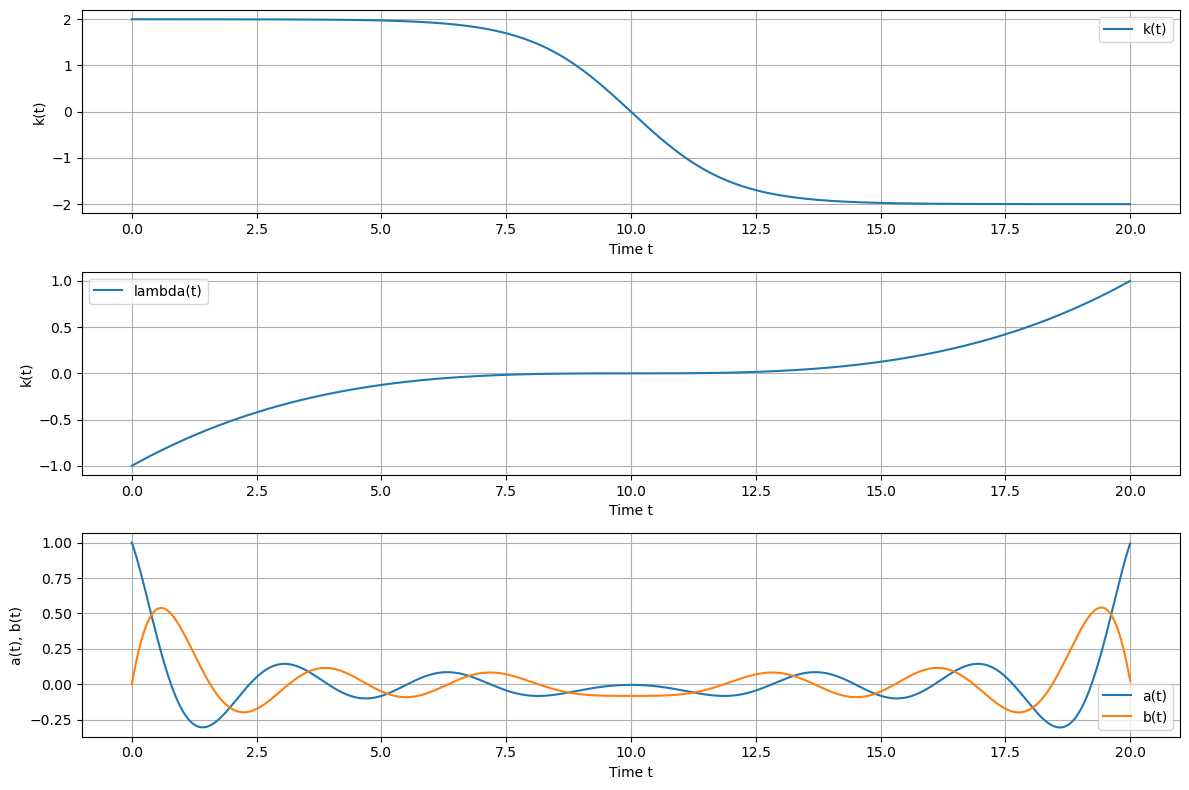

In [13]:
def analytical_solution(Δt, x0, γ_k, k_μ, γ_l, λ_μ):
    a0, b0, k0, λ0 = x0

    # Calculate k(t), lambda(t), a(t) and b(t)
    k_t = np.exp(-γ_k*Δt) * (k0 - k_μ) + k_μ
    λ_t = np.exp(-γ_l*Δt) * (λ0 - λ_μ) + λ_μ

    argument =  (k0 - k_t)/γ_k + k_μ * Δt
    factor = np.exp( (λ0-λ_t)/γ_l + λ_μ * Δt )

    a_t = factor * ( a0 * np.cos(argument) - b0 * np.sin(argument) )
    b_t = factor * ( b0 * np.cos(argument) + a0 * np.sin(argument) )
    
    return a_t, b_t, k_t, λ_t

# Parameters
a0 = 1.0  # Initial value of a
b0 = 0.0  # Initial value of b
k0 = 0.0  # Initial value of k
λ0 = 0.0  # Initial value of λ
gamma_k = .1  # Parameter gamma
k_mu = 2.0  # Parameter k_mu
gamma_l = .1  # Parameter gamma
λ_mu = 0.0  # Parameter λ_mu
n = 4
t = np.linspace(0, 20, 3000)  # Time points

# Compute the analytical solutions
Sol = np.zeros((n, t.shape[0]))
Sol[:,0] = [a0, b0, k0, λ0]
Sol[2,:] = 4*( 1/(1 + np.exp(1*(t - 10))) - .5)
Sol[3,:] = .001*(t-10)**3
for i in range(len(t)):
    if i == 0:
        continue
    dt = t[i] - t[i-1]
    a_t, b_t, k_t, λ_t = analytical_solution(dt, Sol[:,i-1], gamma_k, k_mu, gamma_l, λ_mu)
    Sol[:2,i] = [a_t, b_t]

# Plot the results
plt.figure(figsize=(12, 8))

a_t = Sol[0,:]
b_t = Sol[1,:]
k_t = Sol[2,:]
λ_t = Sol[3,:]

# Plot k(t)
plt.subplot(3, 1, 1)
plt.plot(t, k_t, label='k(t)')
plt.xlabel('Time t')
plt.ylabel('k(t)')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, λ_t, label='lambda(t)')
plt.xlabel('Time t')
plt.ylabel('k(t)')
plt.legend()
plt.grid()

# Plot a(t) and b(t) for the first solution
plt.subplot(3, 1, 3)
plt.plot(t, a_t, label='a(t)')
plt.plot(t, b_t, label='b(t)')
plt.xlabel('Time t')
plt.ylabel('a(t), b(t)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




Signal to noise:  0.9652203621374148


FileNotFoundError: [Errno 2] No such file or directory: 'fig/continuous_time_extended_kalman/simulation/state_time.pdf'

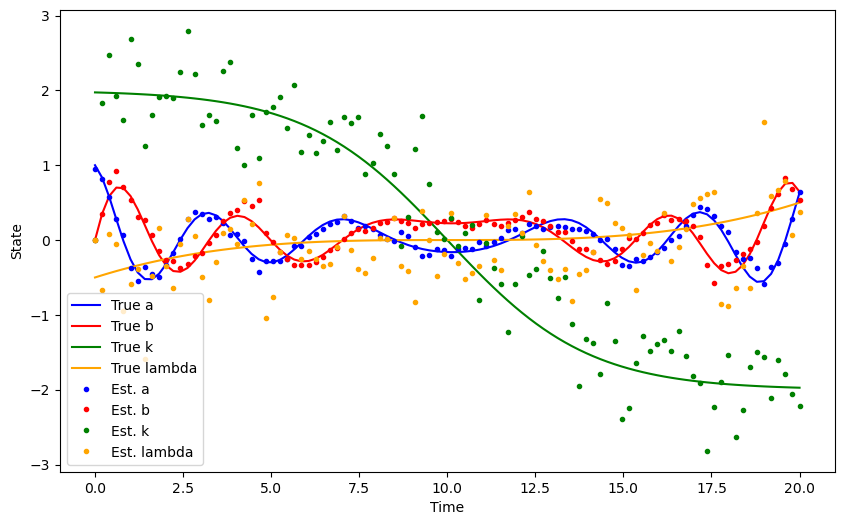

In [14]:
# Define the Jacobian of f
def F_jacobian(x, γ_k, γ_l):
    a, b, k, λ = x
    
    return np.array([
        [λ, -k, -b, a],
        [k, λ, a, b],
        [0, 0, -γ_k,0],
        [0, 0, 0, -γ_l]])

def f_analytical_solution(Δt, x0, γ_k, k_μ, γ_l, λ_μ):
    a0, b0, k0, λ0 = x0

    # Calculate k(t), lambda(t), a(t) and b(t)
    k_t = np.exp(-γ_k*Δt) * (k0 - k_μ) + k_μ
    λ_t = np.exp(-γ_l*Δt) * (λ0 - λ_μ) + λ_μ

    argument =  (k0 - k_t)/γ_k + k_μ * Δt
    factor = np.exp( (λ0-λ_t)/γ_l + λ_μ * Δt )

    a_t = factor * ( a0 * np.cos(argument) - b0 * np.sin(argument) )
    b_t = factor * ( b0 * np.cos(argument) + a0 * np.sin(argument) )
    
    return a_t, b_t, k_t, λ_t

# Define measurement function: inverse fourier transform
def h(x,ω=ω,T=T):
    H = np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0]), np.zeros(T.shape[0])]).T *2/T.shape[0]
    return H @ x

# Define the Jacobian of h
def H_jacobian(x,ω=ω,T=T):
    return np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0]), np.zeros(T.shape[0])]).T *2/T.shape[0]

# P(t)' = F(t)P(t) + P(t)F(t)^T + Q
def dPdt(t,P,F,Q):
    P = P.reshape((4, 4))  # Reshape the 1D array P into a 3x3 matrix
    return (F @ P + P @ F.T + Q).flatten() # Flatten the 3x3 matrix to a 1D array of size 9


# Simulation
n = 4
t_eval = np.linspace(0, 20, 100)
# K as a hill function of time from 2 to -2
k_sim = 4*( 1/(1 + np.exp(.5*(t_eval - 10))) - .5)
# λ as a cubic function of time
λ_sim = .0005*(t_eval-10)**3

true_C = np.zeros((n, t_eval.shape[0]))
true_C[2,:] = k_sim
true_C[3,:] = λ_sim
true_C[:2,0] = [1, 0]
for i,t in enumerate(t_eval):
    if i == 0:
        continue
    dt = t - t_eval[i-1]
    a_t, b_t, k_t, λ_t = analytical_solution(dt, true_C[:,i-1], gamma_k, k_mu, gamma_l, λ_mu)
    true_C[:2,i] = [a_t, b_t]

true_R = h(true_C)
sigma = 0.05
measurements = true_R  + np.random.normal(0,sigma, size=true_R.shape)
print('Signal to noise: ', np.var(true_R)/sigma**2 )

# Initialize parameters
ONE = np.eye(n)
m = T.shape[0]
gamma_k = .1  # Parameter gamma
k_mu = 0 # Parameter k_mu
gamma_l = .5  # Parameter gamma
lambda_mu = 0  # Parameter λ_mu
x_0 = np.array([0, 0, 0, 0])
sigma = 1e-3
Q = np.eye(n)*(sigma)**2
Q[2,2] = 0.001  # Process noise cond covariance
Q[3,3] = 0.001
x_hat = x_0
x_est = np.zeros((len(t_eval),x_hat.shape[0]))
x_est[0] = x_hat
P_pred = ONE.flatten()
P_est = np.zeros((len(t_eval),P_pred.shape[0]))
P_est[0] = P_pred
R = (sigma)**2*np.diag(np.ones(m))  # Measurement noise covariance

# EKF implementation
# Initial state estimate and covariance
x_pred = np.zeros((len(t_eval),x_0.shape[0]))
x_est = np.zeros((len(t_eval),x_0.shape[0]))

P0 = ONE.flatten()
P_pred = np.zeros((len(t_eval),P0.shape[0]))
P_est = np.zeros((len(t_eval),P0.shape[0]))

LL = np.zeros(len(t_eval))

for i in range(len(t_eval)):

    if i == 0:
        x_pred[i] = x_0
        P_pred[i] = P0
    else:
        # Predict
        x_pred[i] = f_analytical_solution(t_eval[i] - t_eval[i-1], x_est[i-1], gamma_k, k_mu, gamma_l, lambda_mu)
        F = F_jacobian(x_pred[i], gamma_k, gamma_l)
        solP = solve_ivp(dPdt, [t_eval[i-1], t_eval[i]], P_est[i-1], args=(F,Q,))
        P_pred[i] = solP.y[:, -1]
        

    # Update
    H = H_jacobian(x_pred[i],ω,T)
    S = np.linalg.multi_dot([H,P_pred[i].reshape((n,n)),H.T]) + R
    K = np.linalg.multi_dot([P_pred[i].reshape((n,n)), H.T, np.linalg.inv(S)])
    y = measurements[:, i] - h(x_pred[i])
    x_est[i] = x_pred[i] + K @ y
    P_est[i] = ( (ONE - K @ H) @ P_pred[i].reshape((n,n)) ).flatten()

    # Save results
    LL[i] = -0.5 * np.linalg.multi_dot([y.T, np.linalg.inv(S), y]) + np.log(np.linalg.det(S)) + m * np.log(2*np.pi)
z_est = h(x_est.T,ω,T)


# Backward smoother
x_smooth = np.zeros(x_est.shape)
P_smooth = np.zeros(P_est.shape)
x_smooth[-1] = x_est[-1]
P_smooth[-1] = P_est[-1]
for i in range(len(t_eval)-2,-1,-1):
    F = F_jacobian(x_est[i], gamma_k, gamma_l)
    J = np.linalg.multi_dot([P_est[i].reshape((n,n)), F.T, np.linalg.inv(P_pred[i+1].reshape((n,n)))])
    x_smooth[i] = x_est[i] + J @ (x_smooth[i+1] - x_pred[i+1])
    P_smooth[i] = ( P_est[i].reshape((n,n)) + J @ (P_smooth[i+1].reshape((n,n)) - P_pred[i+1].reshape((n,n))) @ J.T ).flatten()

P_est = P_est.reshape((len(t_eval),n,n))
z_smooth = h(x_smooth.T,ω,T)
P_smooth = P_smooth.reshape((len(t_eval),n,n))


# Plot results
fig, ax = plt.subplots(1,1,figsize=(10, 6))
ax.plot(t_eval, true_C[0,:], label='True a', color='blue')
ax.plot(t_eval, true_C[1,:], label='True b', color='red')
ax.plot(t_eval, true_C[2,:], label='True k', color='green')
ax.plot(t_eval, true_C[3,:], label='True lambda', color='orange')
ax.plot(t_eval, x_est[:, 0], '.', label='Est. a', color='blue')
ax.plot(t_eval, x_est[:, 1], '.', label='Est. b', color='red')
ax.plot(t_eval, x_est[:, 2], '.', label='Est. k', color='green')
ax.plot(t_eval, x_est[:, 3], '.', label='Est. lambda', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('State')
ax.legend()
# save figure
fig.savefig('fig/continuous_time_extended_kalman/simulation/state_time.pdf',bbox_inches='tight')


fig, ax = plt.subplots(3,1,figsize=(9,5))
plt.colorbar( ax[0].imshow(true_R, aspect='auto') )
ax[0].set_xticks([])
ax[0].set_title('True state')
plt.colorbar( ax[1].imshow(measurements, aspect='auto') )
ax[1].set_xticks([])
ax[1].set_title('Measurements')
plt.colorbar( ax[2].imshow(z_est,  aspect='auto') )
ax[2].set_xticks([])
ax[2].set_title('Estimated')
plt.show()
# save figure
fig.savefig('fig/continuous_time_extended_kalman/simulation/mesurments.pdf',bbox_inches='tight')


[φ_t, a_t, R2_t, pval_t, μ_t] = fourier_transform(true_R.T,T,ω)
[φ_m, a_m, R2_m, pval_m, μ_m] = fourier_transform(measurements.T,T,ω)
[φ_e, a_e, R2_e, pval_e, μ_e] = fourier_transform(z_est.T,T,ω)
Φ = np.ones((3,len(t_eval),3))
Φ[0,:,:] = p2lc(φ_t)
Φ[1,:,:] = p2lc(φ_m)
Φ[2,:,:] = p2lc(φ_e)


fig, ax = plt.subplots(1,1,figsize=(12,3))    
ax.imshow(Φ[[0,2]],aspect='equal',interpolation='none')
# save figure
fig.savefig('fig/continuous_time_extended_kalman/simulation/phase.pdf',bbox_inches='tight')




In [34]:
x0

array([ 1.24089543e+00,  6.83399621e+00, -2.13888389e-03,  0.00000000e+00])

In [40]:
np.linalg.multi_dot([P_est[k].reshape((n,n)), F.T, np.linalg.pinv(P_pred[k+1].reshape((n,n)))])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])